In [1]:
import sys
from pathlib import Path

this_file_path = Path().resolve()
sys.path.append(str(this_file_path.parents[0]))

import pandas as pd
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

# 数据获取并转换

In [16]:
from scr.data_service import get_ts_etf_price,get_ts_index_price

In [ ]:
etf_price: pd.DataFrame = get_ts_etf_price(
    start_date="2014-01-01",
    end_date="2023-02-17",
    fields=["open", "high", "low", "close", "vol",'amount'],
)
etf_price['vol'] *= 100
etf_price['amount'] *= 1000
etf_price.rename(columns={"vol": "volume"}, inplace=True)
etf_price["factor"] = 1

benchmark: pd.DataFrame = get_ts_index_price(
    "000300.SH",
    "2014-01-01",
    "2023-02-17",
    fields=["open", "high", "low", "close", "volume",'amount'],
)

benchmark['volume'] *= 100
benchmark['amount'] *= 1000
benchmark['factor'] = 1

In [ ]:
data_all:pd.DataFrame = pd.concat((etf_price,benchmark))

In [ ]:
ETF_PRICE:str = "../行业有效量价因子/etf_price"

In [ ]:
for code,df in data_all.groupby('code'):
    csv_name:str = '{1}{0}'.format(*code.split('.')).upper() + ".csv"
    df.to_csv(str(ETF_PRICE/csv_name))

In [ ]:
#!cd D:\WrokSpace\visualization_stock_market\sqlalchemy_to_data\qlib_scripts && python dump_bin.py dump_all --csv_path D:\WrokSpace\visualization_stock_market\sqlalchemy_to_data\行业有效量价因子\etf_price --qlib_dir D:\WrokSpace\visualization_stock_market\sqlalchemy_to_data\行业有效量价因子\qlib_etf_data --date_field_name "trade_date" --exclude_fields ('code',)

In [ ]:
!cd e:\WorkSpace\visualization_stock_market\sqlalchemy_to_data\qlib_scripts && python dump_bin.py dump_all --csv_path e:\WorkSpace\visualization_stock_market\sqlalchemy_to_data\行业有效量价因子\etf_price --qlib_dir e:\WorkSpace\visualization_stock_market\sqlalchemy_to_data\行业有效量价因子\qlib_etf_data --date_field_name "trade_date" --exclude_fields ('code',)

2023-02-24 12:29:10.514 | INFO     | __main__:_get_all_date:317 - start get all date......

 43%|████▎     | 537/1240 [00:03<00:02, 276.41it/s]


100%|██████████| 1240/1240 [00:07<00:00, 175.99it/s]
2023-02-24 12:29:17.560 | INFO     | __main__:_get_all_date:340 - end of get all date.

2023-02-24 12:29:17.561 | INFO     | __main__:_dump_calendars:343 - start dump calendars......
2023-02-24 12:29:17.577 | INFO     | __main__:_dump_calendars:348 - end of calendars dump.

2023-02-24 12:29:17.578 | INFO     | __main__:_dump_instruments:351 - start dump instruments......
2023-02-24 12:29:17.580 | INFO     | __main__:_dump_instruments:353 - end of instruments dump.

2023-02-24 12:29:17.581 | INFO     | __main__:_dump_features:356 - start dump features......

  0%|          | 0/1240 [00:00<?, ?it/s]e:\WorkSpace\visualization_stock_market\sqlalchemy_to_data\qlib_scripts\dump_bin.py:228: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  calendars_df[self.date_field_name] = calendars_df[self.date_field_name].astype(
e:\WorkSpace\visualization_stoc

# 初始化qlib

In [2]:
import qlib
from qlib.workflow import R  # 实验记录管理器
from qlib.data import D # 基础行情数据服务的对象
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.constant import REG_CN
from qlib.workflow.record_temp import SignalRecord, SigAnaRecord

In [3]:
qlib.init(provider_uri="qlib_etf_data", region=REG_CN) # 初始化

[30392:MainThread](2023-02-28 14:58:05,080) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[30392:MainThread](2023-02-28 14:58:05,085) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[30392:MainThread](2023-02-28 14:58:05,086) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('E:/WorkSpace/visualization_stock_market/sqlalchemy_to_data/行业有效量价因子/qlib_etf_data')}


# 训练模型实例化

## 价量因子构造

|大类因子|因子名称|计算公式|
|--|--|--|
|动量|二阶动量|$EWMA(\frac{Close_{t}-mean(Close_{t-window_{1:t}})}{mean(Close_{t-window_{1:t}})}-delay(\frac{Close_{t}-mean(Close_{t-window1:t})}{mean(Close_{t-window1:t})},window2),window)$|
|动量|动量期限差|$\frac{Close_{t}-Close_{t-window1}}{Close_{t-window_{1}}}-\frac{Close_{t}-Close_{t-window_{2}}}{Close_{t-window2}}$,window1>window2|
|波动率|成交金额波动|$-STD(Amount)$|
|波动率|成交量波动|$-STD(Volume)$|
|换手率|换手率变化|$\frac{Mean(turnover_{t-window_{1:t}})}{Mean(turnover_{t-window_{2:t}})}$,window1>window2|
|多空对比|多空对比总量|$-\sum^{i=t}_{i=t-window}\frac{Close_{i}-Low_{i}}{Hight_{i}-Close_{i}}$|
|多空对比|多空对比变化|$EWMA(Volume*\frac{(Close-Low)-(High-Close)}{High-Low},window_{1})-EWNA(Volume*\frac{(Close-Low)-(High-Close)}{High-Low},window_{2})$,$window_1>window_2$|
|量价背离|量价背离协方差(收盘价)|$-rank\{covariance[rank(Close),rank(Volume),window]\}$|
|量价背离|量价相关系数(收盘价)|$-correlation(Close,Volume,window)$|
|量价背离|一阶量价背离|$-correlation[Rank(\frac{Volume_{i}}{Volume_{i-1}}-1),Rank(\frac{Close_{i}}{Open_{i}}-1),window]$|
|量幅同向|量幅同向|$correlation[Rank(\frac{Volume_{i}}{Volume_{i-1}}-1),Rank(\frac{High_{i}}{Low_{i}}-1),window]$|

由于研报未给出具体窗口参数。所以再构造因子时使用了5,10,20,60,120,180这几个常用的窗口期,共生成了192个因子。

下图为行业ETF的数量变动情况,在2020年ETF行业占比才到全部行业etf的60%,一共68支，总的来说时间过短。所以后续我们使用全部etf作为标的池。

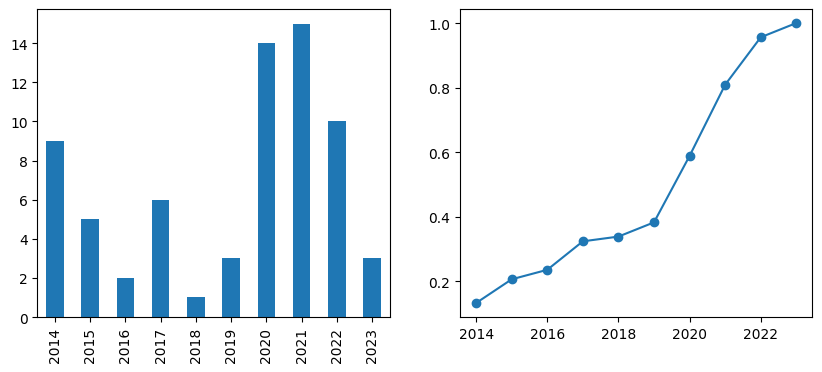

In [4]:
industry_etf:pd.DataFrame = pd.read_csv('../行业有效量价因子/qlib_etf_data/instruments/industry_etf.txt',delimiter='\t',header=None,parse_dates=[1,2])
industry_etf.columns = ['symbol','begin_dt','end_dt']

fig,axes = plt.subplots(1,2,figsize=(10,4))
bar_ax = industry_etf["begin_dt"].dt.year.value_counts().sort_index().plot.bar(ax=axes[0])

line_ax = industry_etf["begin_dt"].dt.year.value_counts().div(
    len(industry_etf)
).sort_index().cumsum().plot(marker='o',ax=axes[1])

In [5]:
###################################
# 参数配置
###################################
# 数据处理器参数配置：整体数据开始结束时间，训练集开始结束时间，股票池
TARIN_PERIODS: Tuple = ("2014-01-01", "2017-12-31")
VALID_PERIODS: Tuple = ("2018-01-01", "2020-12-31")
TEST_PERIODS: Tuple = ("2021-01-01", "2023-02-17")

data_handler_config:Dict = {
    "start_time": TARIN_PERIODS[0],
    "end_time": TEST_PERIODS[1],
    "fit_start_time": TARIN_PERIODS[0],
    "fit_end_time": TARIN_PERIODS[1],
    "instruments": "market",
}

# 任务参数配置
task:Dict = {
    # 机器学习模型参数配置
    "model": {
        # 模型类
        "class": "LGBModel",
        # 模型类所在模块
        "module_path": "qlib.contrib.model.gbdt",
        # 模型类超参数配置，未写的则采用默认值。这些参数传给模型类
        "kwargs": {  # kwargs用于初始化上面的class
            "loss": "mse",
            "colsample_bytree": 0.8879,
            "learning_rate": 0.0421,
            "subsample": 0.8789,
            "lambda_l1": 205.6999,
            "lambda_l2": 580.9768,
            "max_depth": 15,
            "num_leaves": 210,
            "num_threads": 20,
            "early_stopping_rounds": 200,  # 训练迭代提前停止条件
            "num_boost_round": 1000,  # 最大训练迭代次数
        },
    },
    "dataset": {  # 　因子数据集参数配置
        # 数据集类，是Dataset with Data(H)andler的缩写，即带数据处理器的数据集
        "class": "DatasetH",
        # 数据集类所在模块
        "module_path": "qlib.data.dataset",
        # 数据集类的参数配置
        "kwargs": {
            "handler": {  # 数据集使用的数据处理器配置
                "class": "VolumePriceFactor192",  # 数据处理器类，继承自DataHandlerLP
                "module_path": "scr.factor_expr", # 数据处理器类所在模块
                "kwargs": data_handler_config,  # 数据处理器参数配置
            },
            "segments": {  # 数据集时段划分
                "train": TARIN_PERIODS,  # 训练集时段
                "valid": VALID_PERIODS,  # 验证集时段
                "test": TEST_PERIODS,  # 测试集时段
            },
        },
    },
}


# 实例化模型对象
model = init_instance_by_config(task["model"])
# 实例化数据集，从基础行情数据计算出的包含所有特征（因子）和标签值的数据集。
dataset = init_instance_by_config(task["dataset"])  # 类型DatasetH

[25904:MainThread](2023-02-28 12:49:48,788) INFO - qlib.timer - [log.py:128] - Time cost: 65.961s | Loading data Done
[25904:MainThread](2023-02-28 12:50:52,342) INFO - qlib.timer - [log.py:128] - Time cost: 62.911s | ProcessInf Done
d:\anaconda3\lib\site-packages\qlib\data\dataset\processor.py:262: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc(axis=1)[self.cols] = normalize(df[self.cols].values)
[25904:MainThread](2023-02-28 12:52:48,065) INFO - qlib.timer - [log.py:128] - Time cost: 112.926s | ZScoreNorm Done
[25904:MainThread](2023-02-28 12:52:57,434) INFO - qlib.timer - [log.py:128] - Time cost: 7.996s | Fillna Done
[25904:MainThread](2023-02-28 12:53:01,856) INFO - qlib.timer - [log.py:128] - Time cost: 3.390s | DropnaLabel Done
[25904:MainThread](2023-02-

In [6]:
# 保存数据方便后续使用
dataset.config(dump_all=True,recursive=True)
dataset.to_pickle(path="dataset.pkl",dump_all=True)

In [4]:
# 读取dataset
import pickle

with open("dataset.pkl", "rb") as file_dataset:
    dataset = pickle.load(file_dataset)

# dataset数据查询：特征，标签

In [5]:
# 返回（原始数据集中）训练集、验证集、测试集的全部特征和标签数据
# dara_key = "raw"表示返回原始数据 不加则是预处理后的数据
df_train, df_valid, df_test =  dataset.prepare(segments=["train", "valid", "test"], data_key = "raw") 

In [6]:
df_test.head()

SencondMomentum_5_10_20  SencondMomentum_5_10_60  \
datetime   instrument                                                     
2021-01-04 SH501000                   0.003047                 0.001016   
           SH501001                   0.009585                 0.003118   
           SH501005                  -0.001462                 0.001020   
           SH501007                   0.000602                -0.000218   
           SH501008                  -0.004111                -0.001986   

                       SencondMomentum_5_10_120  SencondMomentum_5_10_180  \
datetime   instrument                                                       
2021-01-04 SH501000                    0.000579                  0.000337   
           SH501001                    0.001388                  0.000886   
           SH501005                    0.000520                  0.000284   
           SH501007                   -0.000329                 -0.000317   
           SH501008                   -0.001184                 -0.000892   

                       SencondMomentum_5_20_10  SencondMomentum_5_20_60  \
datetime   instrument                                                     
2021-01-04 SH501000                   0.001665                -0.000185   
           SH501001                   0.016801                 0.002789   
           SH501005                  -0.002197                 0.004115   
           SH501007                  -0.007622                -0.001595   
           SH501008                  -0.008188                -0.002179   

                       SencondMomentum_5_20_120  SencondMomentum_5_20_180  \
datetime   instrument                                                       
2021-01-04 SH501000                   -0.000240                 -0.000256   
           SH501001                    0.001172                  0.000700   
           SH501005                    0.001811                  0.001020   
           SH501007                   -0.001158                 -0.000947   
           SH501008                   -0.001869                 -0.001849   

                       SencondMomentum_5_60_10  SencondMomentum_5_60_20  ...  \
datetime   instrument                                                    ...   
2021-01-04 SH501000                   0.001414                 0.000058  ...   
           SH501001                   0.003856                 0.003934  ...   
           SH501005                   0.000753                 0.004981  ...   
           SH501007                  -0.002710                -0.002037  ...   
           SH501008                  -0.005283                -0.003716  ...   

                       FirstOrderDivergence_60  FirstOrderDivergence_120  \
datetime   instrument                                                      
2021-01-04 SH501000                  -0.336543                 -0.185949   
           SH501001                  -0.212145                 -0.151144   
           SH501005                  -0.091797                 -0.089885   
           SH501007                  -0.014881                 -0.075167   
           SH501008                   0.013137                 -0.033489   

                       FirstOrderDivergence_180  VolumeAmplitudeCoMovement_5  \
datetime   instrument                                                          
2021-01-04 SH501000                   -0.181390                     1.000000   
           SH501001                   -0.111350                    -0.000000   
           SH501005                   -0.092866                     0.208514   
           SH501007                   -0.046048                    -0.261116   
           SH501008                   -0.058342                     0.522976   

                       VolumeAmplitudeCoMovement_10  \
datetime   instrument                                 
2021-01-04 SH501000                       -0.355960   
           SH501001                       -0.105870   
           SH501

## 查看特征定义

In [7]:
fea_expr, fea_name = dataset.handler.get_feature_config()
print('fea_expr',fea_expr)
print()
print('fea_name',fea_name)
print()
print(f'特征个数:{len(fea_expr)}')

fea_expr ['EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),10),20)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),10),60)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),10),120)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),10),180)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),20),10)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),20),60)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),20),120)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),20),180)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),60),10)', 'EMA(($close-Mean($close,5))/Mean($close,5)-Ref(($close-Mean($close,5))/Mean($close,5),60),20)', 'EMA(($close-Mea

# 模型训练

In [10]:
# R变量可以理解为实验记录管理器。
with R.start(experiment_name="train"): # 注意，设好实验名
    # 可选：记录task中的参数到运行记录下的params目录
    R.log_params(**flatten_dict(task))

    # 训练模型，得到训练好的模型model
    model.fit(dataset)
    
    # 可选：训练好的模型以pkl文件形式保存到本次实验运行记录目录下的artifacts子目录，以备后用  
    R.save_objects(trained_model=model)

    # 打印本次实验记录器信息，含记录器id，experiment_id等信息
    print('info', R.get_recorder().info)

[25904:MainThread](2023-02-28 12:55:52,194) INFO - qlib.workflow - [exp.py:258] - Experiment 1 starts running ...
[25904:MainThread](2023-02-28 12:56:00,314) INFO - qlib.workflow - [recorder.py:341] - Recorder 3b6e1cdcc6fa4bfca9dbb96a8d834e52 starts running under Experiment 1 ...


Training until validation scores don't improve for 200 rounds
[20]	train's l2: 0.991661	valid's l2: 0.997286
[40]	train's l2: 0.987937	valid's l2: 0.99698
[60]	train's l2: 0.984541	valid's l2: 0.996843
[80]	train's l2: 0.981764	valid's l2: 0.996876
[100]	train's l2: 0.979113	valid's l2: 0.996974
[120]	train's l2: 0.976548	valid's l2: 0.997143
[140]	train's l2: 0.974128	valid's l2: 0.997303
[160]	train's l2: 0.971881	valid's l2: 0.997457
[180]	train's l2: 0.969606	valid's l2: 0.997721
[200]	train's l2: 0.967701	valid's l2: 0.997866
[220]	train's l2: 0.96572	valid's l2: 0.997982
[240]	train's l2: 0.963667	valid's l2: 0.998179
[260]	train's l2: 0.961885	valid's l2: 0.998408
Early stopping, best iteration is:
[66]	train's l2: 0.983614	valid's l2: 0.996838
info {'class': 'Recorder', 'id': '3b6e1cdcc6fa4bfca9dbb96a8d834e52', 'name': 'mlflow_recorder', 'experiment_id': '1', 'start_time': '2023-02-28 12:56:00', 'end_time': None, 'status': 'RUNNING'}


[25904:MainThread](2023-02-28 12:56:47,580) INFO - qlib.timer - [log.py:128] - Time cost: 0.632s | waiting `async_log` Done


# 预测:在测试集上测试

In [11]:
with R.start(experiment_name="predict"):
 
    # 当前实验的实验记录器：预测实验记录器
    predict_recorder = R.get_recorder()

    # 生成预测结果文件: pred.pkl, label.pkl存放在运行记录目录下的artifacts子目录   
    # 本实验默认是站在t日结束时刻，预测t+2日收盘价相对t+1日开盘价的收益率，计算公式为 Ref($open, -2)/Ref($open, -1) - 1
    sig_rec = SignalRecord(model, dataset, predict_recorder)  # 将训练好的模型、数据集、预测实验记录器传递给信号记录器      
    sig_rec.generate()
    
    # 生成预测结果分析文件，在artifacts\sig_analysis 目录生成ic.pkl,ric.pkl文件
    sigAna_rec = SigAnaRecord(predict_recorder) # 信号分析记录器
    sigAna_rec.generate()

    print('info', R.get_recorder().info)

[25904:MainThread](2023-02-28 12:56:47,940) INFO - qlib.workflow - [exp.py:258] - Experiment 2 starts running ...
[25904:MainThread](2023-02-28 12:56:48,080) INFO - qlib.workflow - [recorder.py:341] - Recorder ea512bd4a0c34b9ca523f8f94fc90bdc starts running under Experiment 2 ...
[25904:MainThread](2023-02-28 12:56:50,142) INFO - qlib.workflow - [record_temp.py:196] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 2


'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2021-01-04 SH501000   -0.010738
           SH501001   -0.017817
           SH501005    0.026794
           SH501007   -0.004022
           SH501008    0.027239
{'IC': 0.03490824582267166,
 'ICIR': 0.3004983310599664,
 'Rank IC': 0.028119127120548548,
 'Rank ICIR': 0.21551384043264335}
info {'class': 'Recorder', 'id': 'ea512bd4a0c34b9ca523f8f94fc90bdc', 'name': 'mlflow_recorder', 'experiment_id': '2', 'start_time': '2023-02-28 12:56:48', 'end_time': None, 'status': 'RUNNING'}


[25904:MainThread](2023-02-28 12:56:52,605) INFO - qlib.timer - [log.py:128] - Time cost: 0.000s | waiting `async_log` Done


# 预测结果查询

In [8]:
# 加载pkl文件 
with R.start():
    train_recorder = R.get_recorder(experiment_id='1',recorder_id='3b6e1cdcc6fa4bfca9dbb96a8d834e52')
    model = train_recorder.load_object("trained_model")
    predict_recorder = R.get_recorder(experiment_id='2',recorder_id='ea512bd4a0c34b9ca523f8f94fc90bdc')

[30392:MainThread](2023-02-28 14:59:20,876) INFO - qlib.workflow - [exp.py:258] - Experiment 4 starts running ...
[30392:MainThread](2023-02-28 14:59:22,582) INFO - qlib.workflow - [recorder.py:341] - Recorder 848b19131be647b7b17eb8a3eec7d1fc starts running under Experiment 4 ...
[30392:MainThread](2023-02-28 14:59:54,276) INFO - qlib.timer - [log.py:128] - Time cost: 0.000s | waiting `async_log` Done


In [9]:
# 这个pkl文件记录的是测试集未经数据预处理的原始标签值
label_df = predict_recorder.load_object("label.pkl") 
# 修改列名LABEL0为label 这个label其实就是下一期得收益率
label_df.columns = ['label'] 

pred_df = predict_recorder.load_object("pred.pkl") # 加载测试集预测结果到dataframe

print('label_df', label_df) # 预处理后的测试集标签值 
print('pred_df', pred_df) # 测试集对标签的预测值，score就是预测值

label_df                           label
datetime   instrument          
2021-01-04 SH501000   -0.042198
           SH501001    0.037559
           SH501005    0.006977
           SH501007    0.005887
           SH501008    0.037768
...                         ...
2023-02-17 SZ180301         NaN
           SZ180401         NaN
           SZ180501         NaN
           SZ180801         NaN
           SZ184801         NaN

[527174 rows x 1 columns]
pred_df                           score
datetime   instrument          
2021-01-04 SH501000   -0.010738
           SH501001   -0.017817
           SH501005    0.026794
           SH501007   -0.004022
           SH501008    0.027239
...                         ...
2023-02-17 SZ180301    0.027862
           SZ180401   -0.005128
           SZ180501   -0.045479
           SZ180801   -0.016787
           SZ184801   -0.041721

[527174 rows x 1 columns]


## IC,Rank IC查询

In [10]:
ic_df = predict_recorder.load_object("sig_analysis/ic.pkl")

ric_df = predict_recorder.load_object("sig_analysis/ric.pkl")

# 所有绩效指标
print("list_metrics", predict_recorder.list_metrics())
# IC均值：每日IC的均值，一般认为|IC|>0.03说明因子有效，注意 -0.05也认为有预测效能，说明负相关显著
print("IC", predict_recorder.list_metrics()["IC"])
# IC信息率：平均IC/每日IC标准差,也就是方差标准化后的ic均值，一般而言，认为|ICIR|>0.6,因子的稳定性合格
print("ICIR", predict_recorder.list_metrics()["ICIR"])
# 排序IC均值，作用类似IC
print("Rank IC", predict_recorder.list_metrics()["Rank IC"])
# 排序IC信息率，作用类似ICIR# 此图用于评价因子单调性，组1是因子值最高的一组，组5是因子值最低的一组。
print("Rank ICIR", predict_recorder.list_metrics()["Rank ICIR"])

list_metrics {'IC': 0.03490824582267166, 'ICIR': 0.3004983310599664, 'Rank IC': 0.028119127120548548, 'Rank ICIR': 0.21551384043264335}
IC 0.03490824582267166
ICIR 0.3004983310599664
Rank IC 0.028119127120548548
Rank ICIR 0.21551384043264335


In [11]:
# 创建测试集"预测"和“标签”对照表
pred_label_df = pd.concat([pred_df, label_df], axis=1, sort=True).reindex(label_df.index)
pred_label_df.head()

score     label
datetime   instrument                    
2021-01-04 SH501000   -0.010738 -0.042198
           SH501001   -0.017817  0.037559
           SH501005    0.026794  0.006977
           SH501007   -0.004022  0.005887
           SH501008    0.027239  0.037768

## 查看IC及分组收益情况

In [12]:
from scr.plotting import plot_qlib_factor_dist

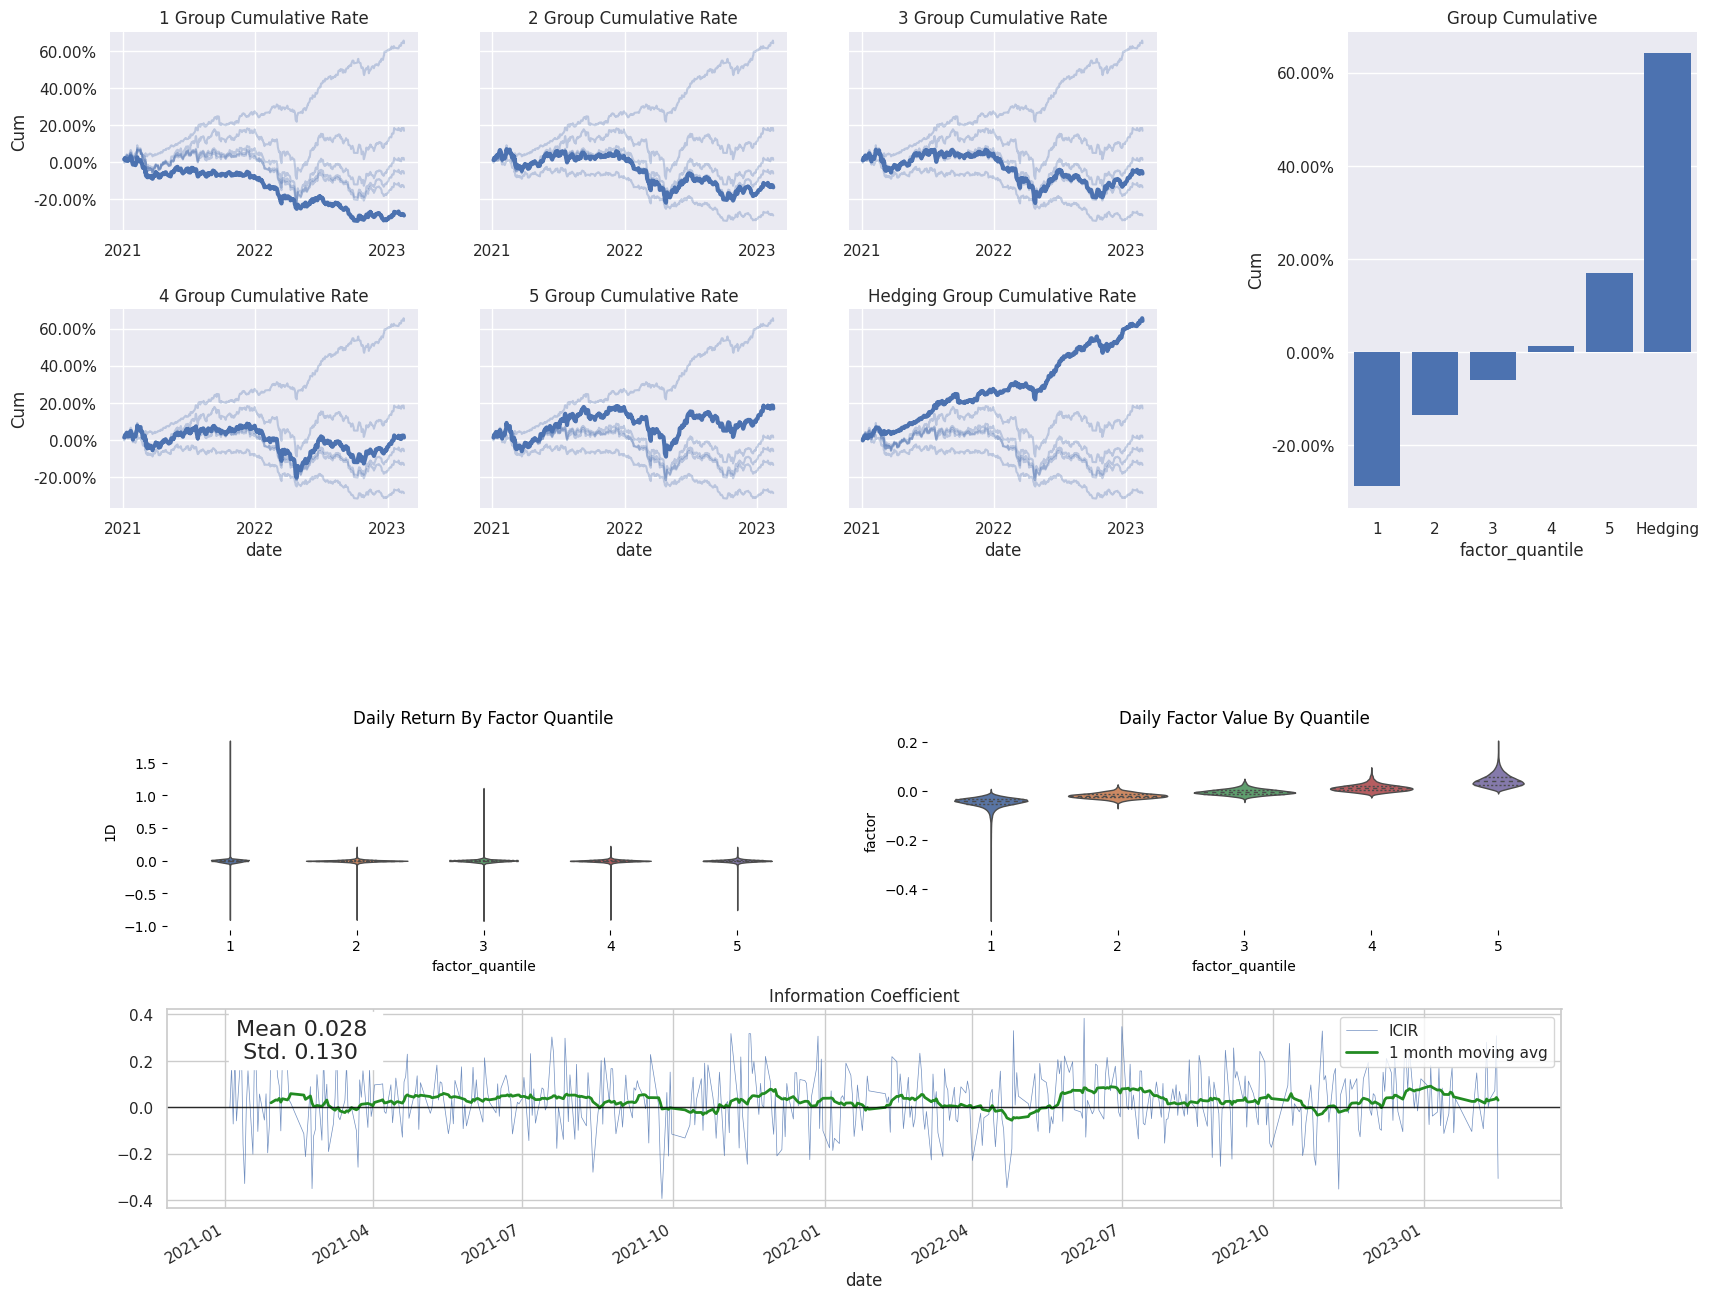

In [14]:
plot_qlib_factor_dist(pred_label_df,no_raise=True)

## 模型特征重要性

In [15]:
# 得到特征重要性系列
if hasattr(model,'get_feature_importance'):
    feature_importance = model.get_feature_importance()

    fea_expr, fea_name = dataset.handler.get_feature_config() # 获取特征表达式，特征名字
    # 特征名，重要性值的对照字典
    feature_importance = {fea_name[int(i.split('_')[1])]: v for i,v in feature_importance.items()}
    pd.Series(feature_importance).sort_values().iloc[-20:].plot.bar()

# 使用Backtrader根据预测值回测

In [16]:
from hugos_toolkit.BackTestTemplate import StockSelectStrategy,get_backtesting,AddSignalData
from hugos_toolkit.BackTestReport.tear import analysis_rets

In [17]:
def get_backtest_data(
    pred_df: pd.DataFrame, start_time: str, end_time: str,market='market'
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    # 定义股票池
    stockpool: List = D.instruments(market=market)
    # 获取test时段的行情原始数据
    raw_data: pd.DataFrame = D.features(
        stockpool,
        fields=["$open", "$high", "$low", "$close", "$volume"],
        start_time=start_time,
        end_time=end_time,
    )
    raw_data: pd.DataFrame = raw_data.swaplevel().sort_index()
    data: pd.DataFrame = pd.merge(
        raw_data, pred_df, how="inner", left_index=True, right_index=True
    ).sort_index()
    data.columns = data.columns.str.replace("$", "", regex=False)
    data: pd.DataFrame = data.reset_index(level=1).rename(
        columns={"instrument": "code"}
    )

    benchmark: pd.DataFrame = D.features(
        ["SH000300"],
        fields=["$close"],
        start_time=start_time,
        end_time=end_time,
    ).reset_index(level=0, drop=True)

    return data, benchmark

In [19]:
data,benchmark = get_backtest_data(pred_df,TEST_PERIODS[0],TEST_PERIODS[1])

In [20]:
benchmark_ret:pd.Series = benchmark['$close'].pct_change()

In [21]:
bt_result = get_backtesting(
    data,
    "test",
    strategy=StockSelectStrategy,
    mulit_add_data=True,
    feedsfunc=AddSignalData,
    strategy_params={"selnum": 5, "pre": 0.05,'ascending':False,'show_log':False},
)

## 回测结果

In [22]:
algorithm_returns: pd.Series = pd.Series(
    bt_result.result[0].analyzers._TimeReturn.get_analysis()
)

In [23]:
report = analysis_rets(algorithm_returns,bt_result.result,benchmark_ret,use_widgets=True)

d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [24]:
for chart in report:
    chart.show()

# Alpha158因子

可以看到华西证券的价量因子虽然在指数上表现较好,但是在ETF上的表现可以说是完全失效的。所以这里我们使用Alpah158因子测试一下其在ETF上的表现如何。

## 构建模型

In [28]:
###################################
# 参数配置
###################################
# 数据处理器参数配置：整体数据开始结束时间，训练集开始结束时间，股票池
TARIN_PERIODS: Tuple = ("2014-01-01", "2019-12-31")
VALID_PERIODS: Tuple = ("2020-01-01", "2020-12-31")
TEST_PERIODS: Tuple = ("2021-01-01", "2023-02-17")


data_handler_config: Dict = {
    "start_time": TARIN_PERIODS[0],
    "end_time": TEST_PERIODS[1],
    "fit_start_time": TARIN_PERIODS[0],
    "fit_end_time": TARIN_PERIODS[1],
    "instruments": "market"
}

# 任务参数配置
task_158: Dict = {
    # 机器学习模型参数配置
    "model": {
        # 模型类
        "class": "LGBModel",
        # 模型类所在模块
        "module_path": "qlib.contrib.model.gbdt",
        # 模型类超参数配置，未写的则采用默认值。这些参数传给模型类
        "kwargs": {
           "loss": "mse",
            "colsample_bytree": 0.8879,
            "learning_rate": 0.0421,
            "subsample": 0.8789,
            "lambda_l1": 205.6999,
            "lambda_l2": 580.9768,
            "max_depth": 15,
            "num_leaves": 210,
            "num_threads": 20,
            "early_stopping_rounds": 200,  # 训练迭代提前停止条件
            "num_boost_round": 1000,  # 最大训练迭代次数
        },
    },
    "dataset": {  # 　因子数据集参数配置
        # 数据集类，是Dataset with Data(H)andler的缩写，即带数据处理器的数据集
        "class": "DatasetH",
        # 数据集类所在模块
        "module_path": "qlib.data.dataset",
        # 数据集类的参数配置
        "kwargs": {
            "handler": {  # 数据集使用的数据处理器配置
                "class": "Alpha158",  # 数据处理器类，继承自DataHandlerLP
                "module_path": "qlib.contrib.data.handler",  # 数据处理器类所在模块
                "kwargs": data_handler_config,  # 数据处理器参数配置
            },
            "segments": {  # 数据集时段划分
                "train": TARIN_PERIODS,  # 训练集时段
                "valid": VALID_PERIODS,  # 验证集时段
                "test": TEST_PERIODS,  # 测试集时段
            },
        },
    },
}


# 实例化模型对象
model_158 = init_instance_by_config(task_158["model"])
# 实例化数据集，从基础行情数据计算出的包含所有特征（因子）和标签值的数据集。
dataset_158 = init_instance_by_config(task_158["dataset"])  # 类型DatasetH

[25904:MainThread](2023-02-28 13:02:32,879) INFO - qlib.timer - [log.py:128] - Time cost: 46.775s | Loading data Done
[25904:MainThread](2023-02-28 13:02:33,813) INFO - qlib.timer - [log.py:128] - Time cost: 0.375s | DropnaLabel Done
d:\anaconda3\lib\site-packages\qlib\data\dataset\processor.py:322: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[25904:MainThread](2023-02-28 13:02:36,417) INFO - qlib.timer - [log.py:128] - Time cost: 2.602s | CSZScoreNorm Done
[25904:MainThread](2023-02-28 13:02:36,459) INFO - qlib.timer - [log.py:128] - Time cost: 3.577s | fit & process data Done
[25904:MainThread](2023-02-28 13:02:36,460) INFO - qlib.timer - [log.py:128] - Time cost: 50.354s | Init data Done


In [29]:
# 保存数据方便后续使用
dataset_158.config(dump_all=True,recursive=True)
dataset_158.to_pickle(path="dataset_158.pkl",dump_all=True)

In [25]:
with open("dataset_158.pkl", "rb") as file_dataset:
    dataset_158 = pickle.load(file_dataset)

## 执行预测工作流

In [30]:
with R.start(experiment_name="ts_workflow"): # 注意，设好实验名
    # 可选：记录task中的参数到运行记录下的params目录
    R.log_params(**flatten_dict(task_158))

    ############
    # 训练
    #############
    model_158.fit(dataset_158)
    
    # 训练好的模型以pkl文件形式保存到本次实验运行记录目录下的artifacts子目录  
    R.save_objects(trained_model=model_158)

    ###############
    # 预测
    #############
    # 本次实验的实验记录器
    recorder_158 = R.get_recorder()
    # 生成预测结果文件
    sig_rec = SignalRecord(model_158, dataset_158, recorder_158)
    sig_rec.generate()

    # 生成预测结果分析文件
    sigAna_rec = SigAnaRecord(recorder_158)
    sigAna_rec.generate()

    # 打印本次实验记录器信息，含记录器id，experiment_id等信息
    print('info', R.get_recorder().info)

[25904:MainThread](2023-02-28 13:02:52,294) INFO - qlib.workflow - [exp.py:258] - Experiment 3 starts running ...
[25904:MainThread](2023-02-28 13:02:52,385) INFO - qlib.workflow - [recorder.py:341] - Recorder f183768a9d7844d691af2e6d18911ec7 starts running under Experiment 3 ...


Training until validation scores don't improve for 200 rounds
[20]	train's l2: 0.984297	valid's l2: 0.991878
[40]	train's l2: 0.976085	valid's l2: 0.989012
[60]	train's l2: 0.969746	valid's l2: 0.987653
[80]	train's l2: 0.964182	valid's l2: 0.986815
[100]	train's l2: 0.959322	valid's l2: 0.986564
[120]	train's l2: 0.954898	valid's l2: 0.986515
[140]	train's l2: 0.950887	valid's l2: 0.986684
[160]	train's l2: 0.947137	valid's l2: 0.986894
[180]	train's l2: 0.943665	valid's l2: 0.987185
[200]	train's l2: 0.940154	valid's l2: 0.98752
[220]	train's l2: 0.936836	valid's l2: 0.987844
[240]	train's l2: 0.933594	valid's l2: 0.988112
[260]	train's l2: 0.930431	valid's l2: 0.988232
[280]	train's l2: 0.927287	valid's l2: 0.988486
[300]	train's l2: 0.924188	valid's l2: 0.988792
Early stopping, best iteration is:
[112]	train's l2: 0.956616	valid's l2: 0.986422


[25904:MainThread](2023-02-28 13:03:28,996) INFO - qlib.workflow - [record_temp.py:196] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 3


'The following are prediction results of the LGBModel model.'
                          score
datetime   instrument          
2021-01-04 SH501000   -0.023785
           SH501001   -0.022348
           SH501005   -0.017039
           SH501007   -0.025094
           SH501008    0.016307
{'IC': 0.09744560294240515,
 'ICIR': 0.5744778803155676,
 'Rank IC': 0.04177154047684606,
 'Rank ICIR': 0.23813887623198604}
info {'class': 'Recorder', 'id': 'f183768a9d7844d691af2e6d18911ec7', 'name': 'mlflow_recorder', 'experiment_id': '3', 'start_time': '2023-02-28 13:02:52', 'end_time': None, 'status': 'RUNNING'}


[25904:MainThread](2023-02-28 13:03:29,722) INFO - qlib.timer - [log.py:128] - Time cost: 0.000s | waiting `async_log` Done


In [26]:
# 加载pkl文件 
with R.start():
    recorder_158 = R.get_recorder(experiment_id='3',recorder_id='f183768a9d7844d691af2e6d18911ec7')
    model_158 = recorder_158.load_object("trained_model")
 

[30392:MainThread](2023-02-28 15:06:02,905) INFO - qlib.workflow - [exp.py:258] - Experiment 4 starts running ...
[30392:MainThread](2023-02-28 15:06:02,943) INFO - qlib.workflow - [recorder.py:341] - Recorder cb19cac1846d41309768374f4bb98bed starts running under Experiment 4 ...
[30392:MainThread](2023-02-28 15:06:08,930) INFO - qlib.timer - [log.py:128] - Time cost: 0.000s | waiting `async_log` Done


In [27]:
label_158_df:pd.DataFrame = recorder_158.load_object("label.pkl")
label_158_df.columns = ["label"]
pred_158_df = recorder_158.load_object("pred.pkl")
# 创建测试集"预测"和“标签”对照表
pred_label_158_df = pd.concat([pred_158_df, label_158_df], axis=1, sort=True).reindex(
    label_158_df.index
)

## IC/Rank IC

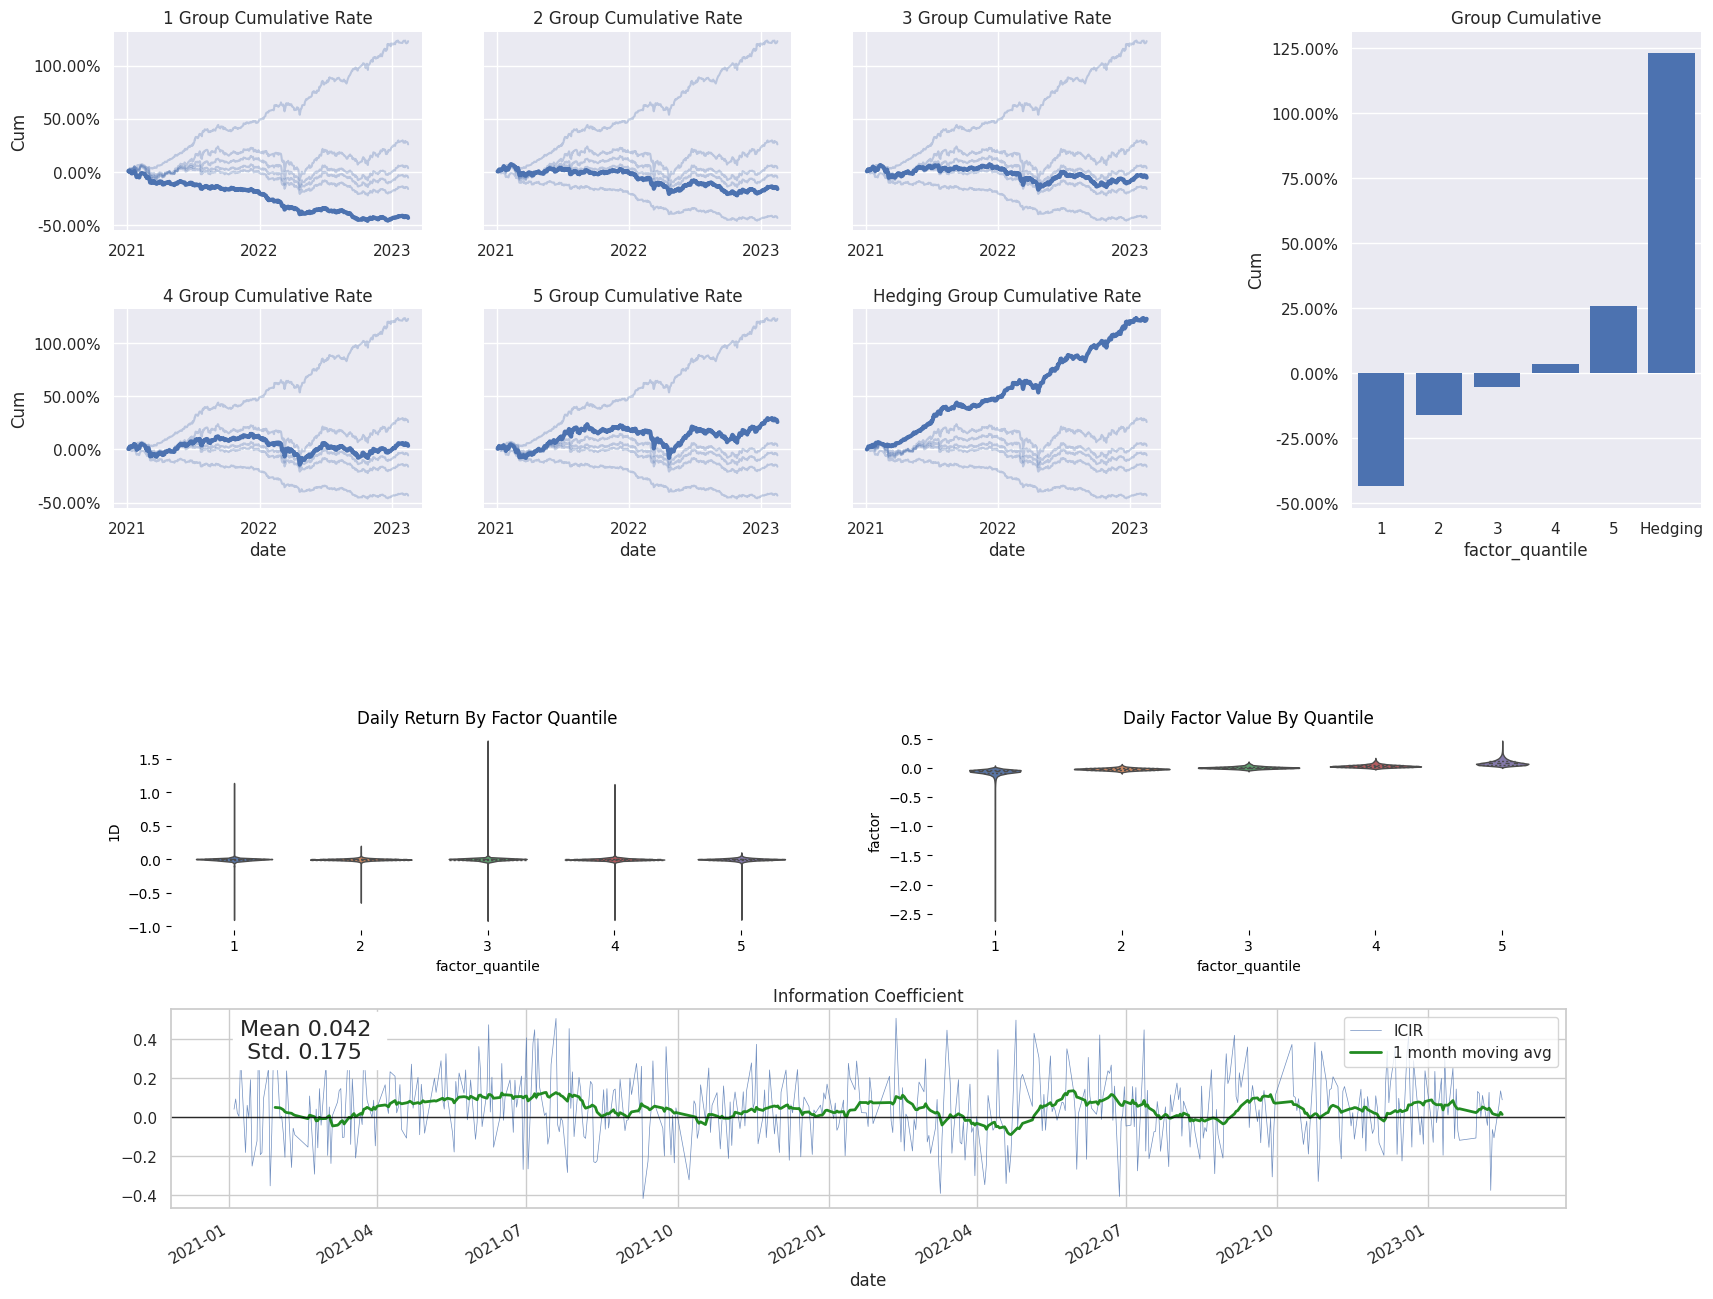

In [28]:
plot_qlib_factor_dist(pred_label_158_df)

## 回测

In [29]:
data_158,benchmark = get_backtest_data(pred_158_df,TEST_PERIODS[0],TEST_PERIODS[1])

In [30]:
bt_158_result = get_backtesting(
    data_158,
    strategy=StockSelectStrategy,
    mulit_add_data=True,
    feedsfunc=AddSignalData,
    strategy_params={"selnum": 5, "pre": 0.05, "ascending": False,'show_log':False},
)

In [31]:
algorithm_returns: pd.Series = pd.Series(
    bt_158_result.result[0].analyzers._TimeReturn.get_analysis()
)

In [32]:
report_158 = analysis_rets(algorithm_returns,bt_158_result.result,benchmark['$close'].pct_change(),use_widgets=True)

d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

d:\anaconda3\lib\site-packages\jupyter_client\session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [33]:
for chart in report_158:
    
    chart.show()